## "Binary Classification with Evaluation Custom Metrics at [Jane Street Market Prediction](https://www.kaggle.com/c/jane-street-market-prediction/overview)"
### Author: [@Satoru Shibata](https://www.kaggle.com/satorushibata)

## Notification:
1. Due to overflow, this Notebook forms the prediction model only;
1. However, the pridiction executed an another Notebook: [Predict Optimized Logit LightGBM Classifier & CNN](https://www.kaggle.com/satorushibata/predict-optimized-logit-lightgbm-classifier-cnn?scriptVersionId=50910895);
1. So, check it also.

# Table of Contents
1. Premise
1. Logit Transformation
1. Customized Sharp Weighted
1. Evaluation Custom Metrics
1. Convolutional Neural Network with Weighted AUC
1. Save files

# 1. Premise
## Required library

In [1]:
%%time
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import os
import random
from functools import partial
import lightgbm as lgb
from sklearn import preprocessing
import gc
import multiprocessing
from sklearn.metrics import roc_auc_score
from scipy.special import logit, expit
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.utils import resample
import seaborn as sns
import numba
import datatable as dtable
from tqdm.notebook import tqdm
import re
from sklearn.model_selection import TimeSeriesSplit, KFold, train_test_split

CPU times: user 609 ms, sys: 118 ms, total: 727 ms
Wall time: 1.62 s


In [2]:
%%time
import keras
from keras.models import Sequential
from keras.layers import Conv2D,MaxPool2D,Dense,Dropout,Softmax,Input,Flatten
from keras.optimizers import Adam,RMSprop,SGD
from keras.layers.merge import add
from keras.layers import Dense, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import BatchNormalization

CPU times: user 1.5 s, sys: 340 ms, total: 1.84 s
Wall time: 3.83 s


## Initial conditions

In [3]:
%%time
splits = int(5)
SEED = 200
num_boost_round = int(100)
early_stopping_rounds = int(5)
verbose_eval = int(5)

"""
SEED = 2000
num_boost_round = int(1000)
early_stopping_rounds = int(50)
verbose_eval = int(50)
"""

CPU times: user 17 µs, sys: 3 µs, total: 20 µs
Wall time: 25.3 µs


'\nSEED = 2000\nnum_boost_round = int(1000)\nearly_stopping_rounds = int(50)\nverbose_eval = int(50)\n'

In [4]:
%%time
# Function to seed everything
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
seed_everything(SEED)

CPU times: user 112 µs, sys: 23 µs, total: 135 µs
Wall time: 140 µs


## Load data
### Source files:
- [Visualization Model with Customized Sharp Weighted](https://www.kaggle.com/satorushibata/visualization-model-with-customized-sharp-weighted)
- [Optimize LightGBM HyperParameter with Optuna](https://www.kaggle.com/satorushibata/optimize-lightgbm-hyperparameter-with-optuna)

In [5]:
%%time
lgb_params = pd.read_pickle('../input/optimize-lightgbm-hyperparameter-with-optuna/LightGBM_Hyperparameter.pickle')
X_train = pd.read_pickle('../input/research-with-customized-sharp-weighted/X_train.pickle')
y_train = pd.read_pickle('../input/research-with-customized-sharp-weighted/y_train.pickle')
groups = np.load('../input/research-with-customized-sharp-weighted/groups.pickle', allow_pickle = True)
resps = np.load('../input/research-with-customized-sharp-weighted/resps.pickle', allow_pickle = True)
weightes = np.load('../input/research-with-customized-sharp-weighted/weightes.pickle', allow_pickle = True)

CPU times: user 705 ms, sys: 2.73 s, total: 3.43 s
Wall time: 27.9 s


# 2. [Logit Transformation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.logit.html)

> ## [Logistic Regression](https://github.com/andersonvom/ml-class/blob/master/06.Logistic.Regression.markdown)
> ### Classification Problems

> 	## Binary classification
> 	y ∈ {0, 1}
> 	0: "Negative class" (e.g. benign tumor)
> 	1: "Positive class" (e.g. malignant tumor)
	
> 	## Multi class classification
> 	y ∈ {0, 1, 2, 3, 4}

>  Linear regression for classification problems is not a good idea. 


> ### Hipothesis Representation

> In order to get `0 <= h(x) <= 1`:

 	h(x) = g(Θ' * x)
	g(z) = 1 / (1 + e^(-z)) # sigmoid function or logistic function

> Since `0 <= h(x) <= 1`, this can be interpreted as the probability of _y = 1_ on input _x_.

 	x = [x0 x1] = [1 tumorSize]
 	h(x) = 0.7
 	# then tell the patient there is a 70% chance of tumor being malignant

> Because of this interpretation, we have that:

 	P(y=0|x;Θ) + P(y=1|x;Θ) = 1
 	P(y=0|x;Θ) = 1 - P(y=1|x;Θ)

>  #### Decision Boundary

> Suppose there are two possible predictions: y = {0, 1}. Based on the function _g(z)_, _h(x)_ will be 0.5 when _z = 0_, where _z = Θ' * x_. Thus we will:

 	predict "y=1" if h(x) ≥ 0.5
 	predict "y=0" if h(x) ≤ 0.5 (less than)

> **Decision boundary** is the name given to the line/plane that divides the categories that we are trying to classify. It is a property of the hipothesis function _h(x)_ and not of the data set. That means it is the plane generated by the hipothesis function. Whenever `Θ' * x >= 0`, then we are predicting `y=1`. On the other hand, when `Θ' * x < 0` then we are predicting `y=0`.

> More complex decision boundaries can be calculated, just as before, by adding new features according to how we want the boundary to look like and performing that operation in the features. For example:

 	h(x) = g(Θ0 + Θ1x1 + Θ2x2 + Θ3x1² + Θ4x2²)
	
 	# if we choose Θ = [-1 0 0 1 1], then we predict:
 	"y = 1" if -1 + x1² + x2² >= 0
 	x1² + x2² >= 1
	
 	# So, for h(x) = 0.5
 	x1² + x2² = 1

> ### Cost Function

> The cost function used for linear regression is not a good choice for logistic regression because given the sigmoid function involved, it would be non-convex. Running gradient descent in a non-convex function can converge to a local minimum that is different than the global minimum.

> A good cost function _J_ that is guaranteed to be convex (and also non-negative) is:

 	Cost(h(x), y) = |   -log(h(x)), if y=1
 	                | -log(1-h(x)), if y=0

> When plotting the two funcions, we can see that for _y=1_, the cost goes very high when _h(x)_ approaches 0, and for _y=0_, the cost goes very high when _h(x)_ approaches 1. This is actually very good for our purposes.


> ### Simplified Cost Function and Gradient Descent

> We can further simplify both _Cost(h(x), y)_ and _J(Θ)_:

> 	Cost(h(x), y) = -y * log(h(x)) - (1-y) * log(1 - h(x))
	
> 	# replacing these values on our original cost function J, we have:
	
> 	J(Θ) = -(1/m) * ∑( y * log(h(x)) + (1-y) * log(1 - h(x)) )

> To use gradient descent to minimize the cost function _J_, we will use the same template used for linear regression.

	repeat {
		# simultaneously update all Θj
		Θj = Θj - α * ∂/∂Θj (J(Θ))
	}
	
 	# and the partial derivative of J(Θ) is described as:
	∂/∂Θj (J(Θ)) = (1/m) * ∑( (h(x) - y) * xj )
	
 	# keeping in mind that the hipothesis function is:
	h(x) = 1 / (1 + e^(Θ'*x))

> To apply logistic regression, it is convenient to use a vectorized notation when updating all values of theta. To do this, the update of theta would be:

> 	Θ = Θ - α * (1/m) * ∑( (h(x) - y) * x )


> ### Advanced Optimization

> * Gradient Descent
> * Conjugate Gradient
> * BFGS
> * L-BFGS

> * Advantages
    - No need to manually pick α
    - Often faster than gradient descent
> * Disadvantages
    - More complex

> Octave implements a minimization function called `fminunc` (function minimum unconstrained) that, provided a initial guess for theta and a costo function that computes both the cost function and the partial derivatives for theta iteration, returns the optimum theta and the value for _J(Θ)_.

> 	# Example
	theta' = [ Θ1, Θ2, Θ3, ..., Θn+1 ]
	function [jVal, gradient] = costFunction(theta)
		jVal = [code to compute _J(Θ)_];
		gradient(1) = [code to compute ∂/∂Θ1 (J(Θ))]
		...
		gradient(n+1) = [code to compute ∂/∂Θn+1 (J(Θ))]


> ### Multi-class Classification: One-vs-All

> * Email foldering/tagging: Work, Friends, Family, Hobby (y = [1,2,3,4])
> * Medical diagrams: Not ill, Cold, Flu (y = [1,2,3])
> * Weather: Sunny, Cloudy, Rain, Snow (y = [1,2,3,4])

> The one-vs-all (one-vs-rest) approach uses logistic regression to create _n_ classifiers that know how to separate each class from all others (becoming a regular logistic regression problem).

> For each clas _i_, train a logistic regression classifier hi(x) to predict the probability of _y=i_. On a new input _x_, pick the class _i_ that maximizes `max(hi(x))`, because that would be the most confident prediction.

In [6]:
%%time
y_train_logit = expit(logit(y_train))

CPU times: user 69.6 ms, sys: 3.34 ms, total: 72.9 ms
Wall time: 72.4 ms


In [7]:
%%time
# Histogram
def distribution(df):
    plt.figure()
    sns.distplot(df, kde=True, rug=True, hist=True, norm_hist=True, axlabel='Frequency Distribution')
    plt.legend()
    plt.show()

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.2 µs


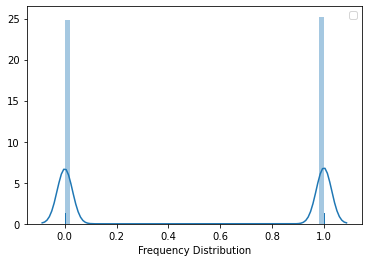

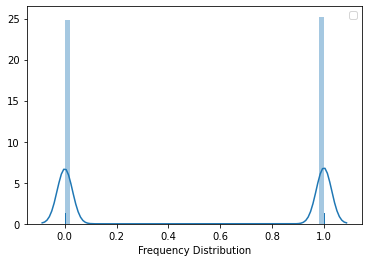

CPU times: user 37.9 s, sys: 916 ms, total: 38.9 s
Wall time: 39.1 s


In [8]:
%%time
distribution(y_train)
distribution(y_train_logit)

# 3. [Customized Sharp Weighted](https://www.kaggle.com/haozhuai/expanding-window-sharp-weighted-return)

In [9]:
%%time
def group_time_split(groups: np.ndarray, splits, X):
    group_list = np.unique(groups)
    n_samples = len(X)
    n_groups = len(group_list)
    indices = np.arange(n_samples)
    test_size = n_groups // splits
    test_starts = range(test_size + n_groups % splits, n_groups, test_size)
    test_starts = list(test_starts)
    for test_start in test_starts:
        yield (
            indices[np.isin(groups, group_list[:test_start])],
            indices[np.isin(groups, group_list[test_start:])],
        )

def utility_score_last(date, weight, resp, action):
    count_i = date[-1] + 1
    Pi = np.bincount(date, weight * resp * action)
    t = np.sum(Pi) / np.sqrt(np.sum(Pi ** 2)) * np.sqrt(250 / count_i)
    u = np.clip(t, 0, 6) * np.sum(Pi)
    return u

def get_opt_threshold(pred, y_true, groups, weights, bins=50):
    p_min, p_max = pred.min(), pred.max()
    opt_u = 0
    opt_th = p_min
    for th in np.linspace(p_min, p_max, endpoint=False, num=bins):
        act = np.where(pred > th, 1, 0)
        u = utility_score_last(groups, weights, y_true, act)
        if u > opt_u:
            opt_u = u
            print(u)
            opt_th = th
    return opt_th

CPU times: user 0 ns, sys: 12 µs, total: 12 µs
Wall time: 16.9 µs


# 4. [Evaluation Custom Metrics](https://www.kaggle.com/c/jane-street-market-prediction/overview/evaluation)
1. Utility Score on LightGBM Classifier
    - Eval_mse_modified_1
    - Eval_mse_modified_2
1. Weighted AUC on CatBoost Classifier
    - Using LightGBM Classifier with Eval_mse_modified_1 & 2

## [Utility Score on LightGBM](https://www.kaggle.com/anlgrbz/approx-utility-score-for-regress-weighted-traing)

> ### Proxy Metrics for Utility Score to Use in Regression 
> ### &
> ### Custom Objective Function Implementations for LGBM


> #### Why regression might be more appropriate?
> In this notebook, I will create proxy metrics to turn classification task into a regression task. I wanted to try and see the effect of structuring this problem as a regression problem instead of classification because "resp" includes more information compared to a binary label as "action". 


> #### How those Custom Objective Functions are related with Evaluation Metric i.e Utility Score?

> I started with adding variations of penalty terms to MSE and MAE if predicted "resp" and true "resp" doesn't have the same sign. This modification is for assigning specific importance for the match between predicted "action" and the true "action" on top of the penalty due to residuals between predicted and actual "resp". This property would allow those new metrics to be used as a proxy to Utility score in a regression setting.


> #### Modified MSE Derivation

> $$Modified MSE = f(\hat{y}) = \sum_{j}(y_j - \hat{y}_j)^2 + \left\{
> \begin{array}{ll}
     >  0  &, y . \hat{y}_j > 0 ; \\
     >  - \lambda . y_j . \hat{y}_j   &, y_j . \hat{y}_j \leq 0 \\
> \end{array} 
> \right.$$

> $y_j$ :  True "resp" value for row j.

> $\hat{y}_j$ :  Predicted "resp" value for row j.

> $ \lambda $ : Parameter to control amount of penalty for non matching action predictions. Needs to be tuned.

> **Piecewise part of the metric represents the extra penalty for non matching true and predicted action. If predicted and true "resp" doesn't have the same label, their multiplication will be smaller than 0 and piecewise function will add extra penalty of $y . \hat{y}$**


> ### Gradient and Hessian 
> I will be implementing objective functions of the different variants of Modified MSE type hybrid metrics in the code below but before starting that part, I wanted to calculate the gradient and hessian for this example -- as gradient and hessian is required to be calculated for objective funcitons in LGBM. 

> $$ Gradient  Modified MSE =  \frac{\partial f(\hat{y})}{\partial \hat{y}} = \sum_{j} -2(y_j - \hat{y}_j) + \left\{
> \begin{array}{ll}
      > 0  &, y . \hat{y}_j > 0 \\
      > - \lambda . y_j   &, y_j . \hat{y}_j \leq 0 \\
> \end{array} 
> \right.$$

> $$ Hessian  Modified MSE = \frac{\partial^2 f(\hat{y})}{\partial \hat{y}^2} = 2 $$

> There are 2 requirement for an objective function which are ;

> - It should be differentiable to first and second level wrt. $\hat{y}_j$ as those derivatives will be gradient and hessian to be used in the underlying optimisation algorithm to minimize objective function.

> - Being differentiable implies another condition which is being continous.

> We can quickly have a look at the shape of those objective functions using a 3-d plot. I will set $\lambda = 2$ to be able to visualise in 3-d

In [10]:
import plotly.graph_objects as go
lmbda = 2
x = np.outer(np.linspace(-0.5, 0.5, 30), np.ones(30))
y = x.copy().T # transpose
z=np.where(x*y>=0, (y-x)**2, ((y-x)**2) - (x*y)*lmbda )
#z = (y-x)**2 -x*y

trace = go.Surface(x = x, y = y, z =z )
data = [trace]
layout = go.Layout(title = '3D Surface plot')
fig = go.Figure(data = data)
fig.update_layout(title='MSE Modified 1 Objective function values', autosize=False,
                  width=500, height=500,
                  margin=dict(l=80, r=70, b=85, t=110),
scene = dict(xaxis_title='Predicted resp',yaxis_title='True resp',zaxis_title='Value of Objective Function'))
fig.show()

> Given that resp is ranged between -0.5 and 0.5 in the training set, I restricted those axis on $|resp_{pred}|<0.5$ and $|resp_{true}|<0.5$.

In [11]:
lmbda = 2
x = np.outer(np.linspace(-0.5, 0.5, 30), np.ones(30))
y = x.copy().T # transpose
z=np.where(x*y>=0, abs(y-x), abs(y-x) - (x*y)*lmbda )
trace = go.Surface(x = x, y = y, z =z )
data = [trace]
layout = go.Layout(title = '3D Surface plot')
fig = go.Figure(data = data)
fig.update_layout(title='MAE Modified 1 Objective function values', autosize=False,
                  width=500, height=500,
                  margin=dict(l=80, r=70, b=85, t=110),
scene = dict(xaxis_title='Predicted resp',yaxis_title='True resp',zaxis_title='Value of Objective Function'))
fig.show()

In [12]:
%%time
def Eval_mse_modified_1(y_true, y_pred):
    lmbda = 0.2
    #weight = y_true.get_weight()
    # y_true = y_true.get_label()
    residual = (y_true - y_pred).astype("float")
    signs_matching = (y_true * y_pred) >= 0
    mse_action_value = np.where(signs_matching,  residual**2, residual**2 - y_true*y_pred*lmbda)
    return "MSE_Modified_1", np.mean(mse_action_value), False

def Eval_mse_modified_2(y_true, y_pred):
    lmbda = 2
    #weight = y_true.get_weight()
    #y_true = y_true.get_label()
    residual = (y_true - y_pred).astype("float")
    signs_matching = (y_true * y_pred) >= 0
    value = np.where(signs_matching,  residual**2, residual**2 + (y_true**2)*(y_pred**2)*lmbda)    
    #value = weight* value 
    return "MSE_Modified_2", np.mean(value), False

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.68 µs


## [LightGBM Classifier](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html) with [Utility Score](https://www.kaggle.com/anlgrbz/approx-utility-score-for-regress-weighted-traing): Weighted AUC for Evaluation Metrics

In [13]:
%%time
def Plot_lgb(Class):
    plt.figure()
    lgb.plot_importance(Class, importance_type = 'gain')
    plt.legend()
    plt.show()
    lgb.plot_tree(Class, figsize=(30, 50))
    plt.legend()
    plt.show()

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.2 µs


In [14]:
def Weighted_AUC(lgb_params, X_train: pd.DataFrame, y_train:pd.DataFrame, groups: np.ndarray, splits=splits):
    
    # Preparation
    Weighted_AUC = 0
    div = splits * (splits - 1) / 2

    for i, (tr_idx, val_idx) in enumerate(group_time_split(groups, splits, X_train)):
        tr_X = X_train.iloc[tr_idx]
        tr_y = y_train.iloc[tr_idx]
        val_X = X_train.iloc[val_idx]
        val_y = y_train.iloc[val_idx]
        
        # LightGBM Classifier Model
        Class = lgb.LGBMClassifier(
            task = 'train',
            boosting_type = 'gbdt',
            objective = 'binary',
            random_state = SEED,
            importance_type = 'gain',
            n_estimators = num_boost_round,
            n_jobs = multiprocessing.cpu_count(),
            metric = [Eval_mse_modified_1, Eval_mse_modified_2]

        )
        Class.set_params(
            **lgb_params
        )
        Class.fit(
            tr_X, 
            tr_y, 
            eval_set=[(tr_X, tr_y), (val_X, val_y)], 
            eval_metric = lambda y_true, y_pred: [Eval_mse_modified_1(y_true, y_pred), Eval_mse_modified_2(y_true, y_pred)],
            early_stopping_rounds=early_stopping_rounds,
            verbose = verbose_eval
        )
        # Polts
        print(Plot_lgb(Class))
        # Predict
        val_pred = Class.predict_proba(val_X)[:, 1]     
        # Evaluation Metrics
        Weighted_AUC += (i + 1) * roc_auc_score(val_y, val_pred) / div
        # Clean the memory
        gc.collect()

# 5. [Convolutional Neural Network](https://keras.io/ja/models/model/) with Weighted AUC

In [15]:
%%time
X_train_adv, X_valid_adv, y_train_adv, y_valid_adv = \
    train_test_split(X_train, y_train_logit, test_size=0.33, random_state=int(SEED), shuffle=True)

CPU times: user 2.64 s, sys: 368 ms, total: 3.01 s
Wall time: 3.01 s


Training until validation scores don't improve for 5 rounds
[5]	training's MSE_Modified_1: 0.248147	training's MSE_Modified_2: 0.248147	valid_1's MSE_Modified_1: 0.24987	valid_1's MSE_Modified_2: 0.24987
[10]	training's MSE_Modified_1: 0.246946	training's MSE_Modified_2: 0.246946	valid_1's MSE_Modified_1: 0.249807	valid_1's MSE_Modified_2: 0.249807
[15]	training's MSE_Modified_1: 0.246167	training's MSE_Modified_2: 0.246167	valid_1's MSE_Modified_1: 0.249795	valid_1's MSE_Modified_2: 0.249795
[20]	training's MSE_Modified_1: 0.245583	training's MSE_Modified_2: 0.245583	valid_1's MSE_Modified_1: 0.249781	valid_1's MSE_Modified_2: 0.249781
Early stopping, best iteration is:
[19]	training's MSE_Modified_1: 0.245683	training's MSE_Modified_2: 0.245683	valid_1's MSE_Modified_1: 0.249772	valid_1's MSE_Modified_2: 0.249772


<Figure size 432x288 with 0 Axes>

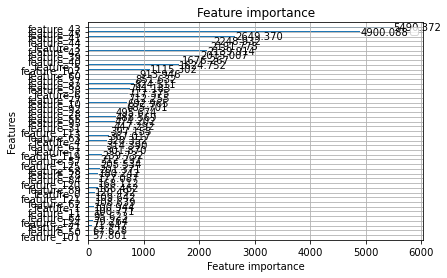

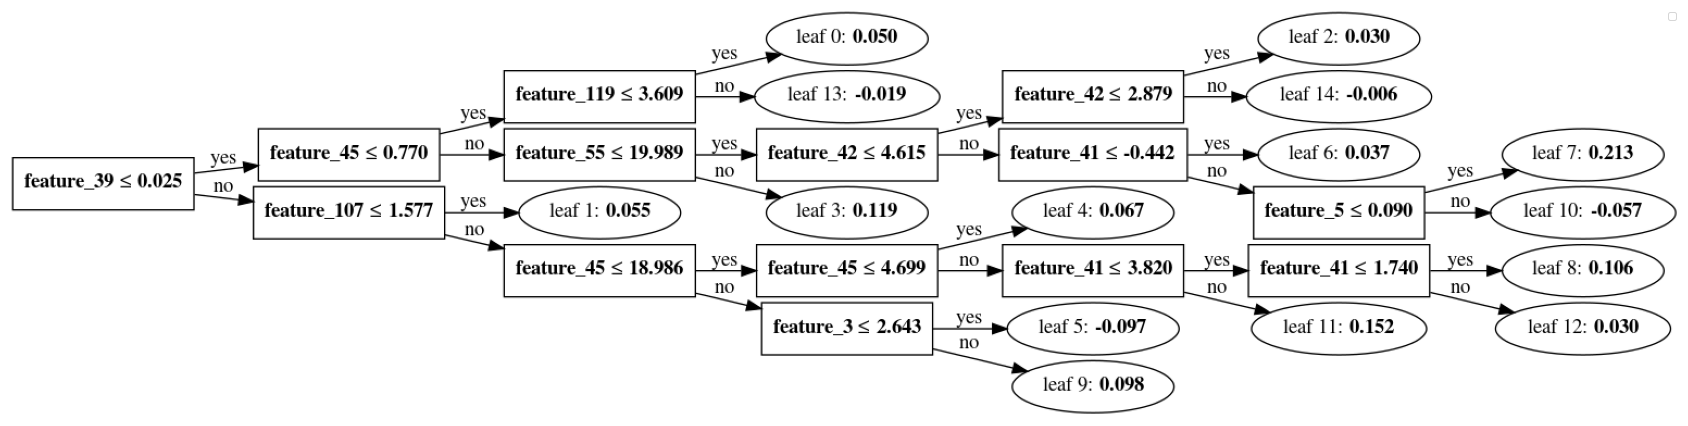

None
Training until validation scores don't improve for 5 rounds
[5]	training's MSE_Modified_1: 0.248843	training's MSE_Modified_2: 0.248843	valid_1's MSE_Modified_1: 0.249845	valid_1's MSE_Modified_2: 0.249845
[10]	training's MSE_Modified_1: 0.248148	training's MSE_Modified_2: 0.248148	valid_1's MSE_Modified_1: 0.24978	valid_1's MSE_Modified_2: 0.24978
[15]	training's MSE_Modified_1: 0.247601	training's MSE_Modified_2: 0.247601	valid_1's MSE_Modified_1: 0.249788	valid_1's MSE_Modified_2: 0.249788
Early stopping, best iteration is:
[11]	training's MSE_Modified_1: 0.248025	training's MSE_Modified_2: 0.248025	valid_1's MSE_Modified_1: 0.24978	valid_1's MSE_Modified_2: 0.24978


<Figure size 432x288 with 0 Axes>

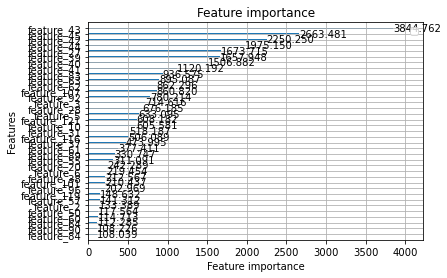

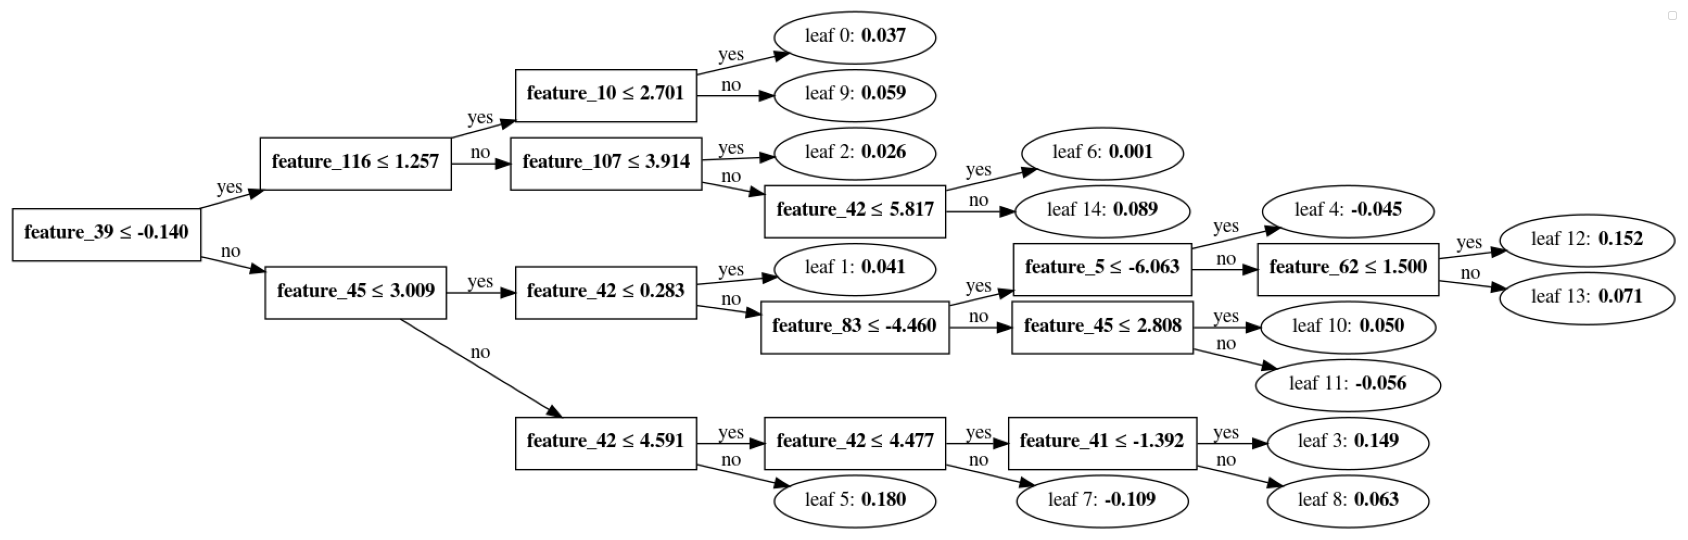

None
Training until validation scores don't improve for 5 rounds
[5]	training's MSE_Modified_1: 0.249167	training's MSE_Modified_2: 0.249167	valid_1's MSE_Modified_1: 0.249909	valid_1's MSE_Modified_2: 0.249909
[10]	training's MSE_Modified_1: 0.248667	training's MSE_Modified_2: 0.248667	valid_1's MSE_Modified_1: 0.249854	valid_1's MSE_Modified_2: 0.249854
[15]	training's MSE_Modified_1: 0.248265	training's MSE_Modified_2: 0.248265	valid_1's MSE_Modified_1: 0.249831	valid_1's MSE_Modified_2: 0.249831
[20]	training's MSE_Modified_1: 0.247981	training's MSE_Modified_2: 0.247981	valid_1's MSE_Modified_1: 0.249797	valid_1's MSE_Modified_2: 0.249797
[25]	training's MSE_Modified_1: 0.247681	training's MSE_Modified_2: 0.247681	valid_1's MSE_Modified_1: 0.249789	valid_1's MSE_Modified_2: 0.249789
[30]	training's MSE_Modified_1: 0.247447	training's MSE_Modified_2: 0.247447	valid_1's MSE_Modified_1: 0.249749	valid_1's MSE_Modified_2: 0.249749
[35]	training's MSE_Modified_1: 0.247252	training's MS

<Figure size 432x288 with 0 Axes>

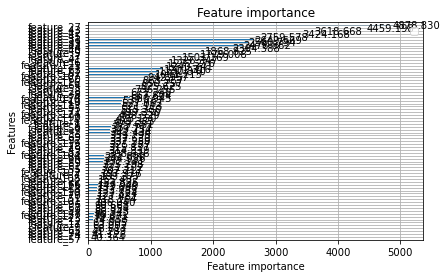

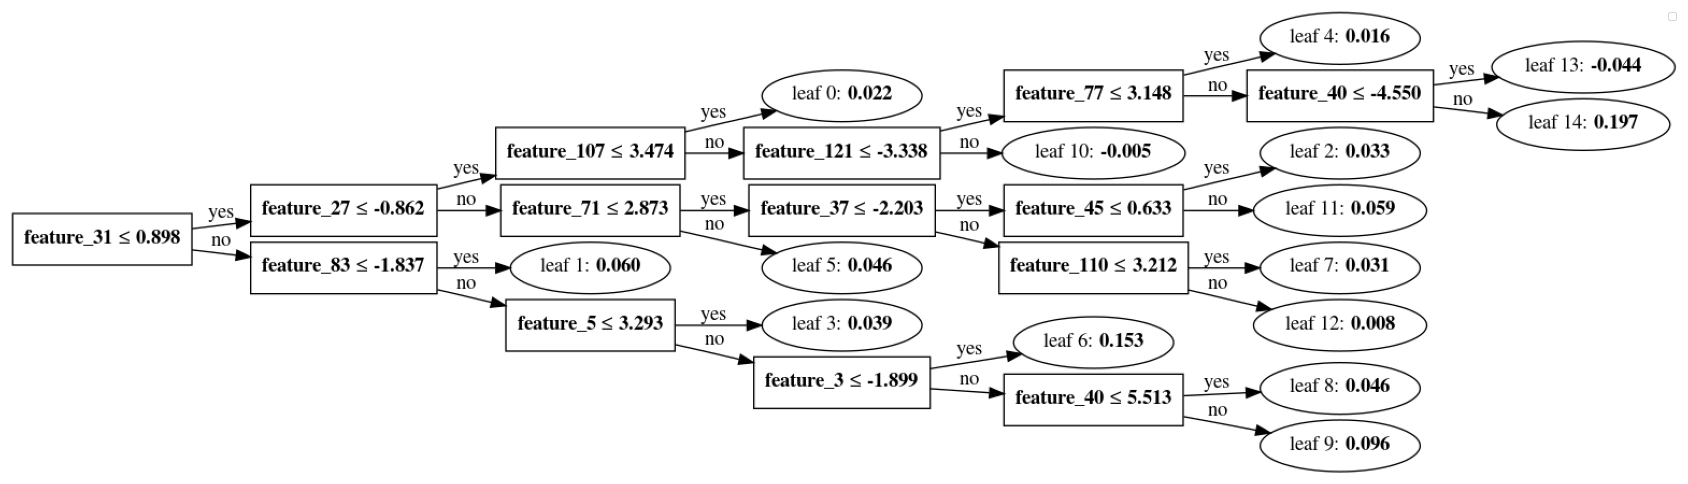

None
Training until validation scores don't improve for 5 rounds
[5]	training's MSE_Modified_1: 0.249347	training's MSE_Modified_2: 0.249347	valid_1's MSE_Modified_1: 0.249924	valid_1's MSE_Modified_2: 0.249924
[10]	training's MSE_Modified_1: 0.248967	training's MSE_Modified_2: 0.248967	valid_1's MSE_Modified_1: 0.249855	valid_1's MSE_Modified_2: 0.249855
[15]	training's MSE_Modified_1: 0.248687	training's MSE_Modified_2: 0.248687	valid_1's MSE_Modified_1: 0.249777	valid_1's MSE_Modified_2: 0.249777
[20]	training's MSE_Modified_1: 0.248481	training's MSE_Modified_2: 0.248481	valid_1's MSE_Modified_1: 0.249733	valid_1's MSE_Modified_2: 0.249733
[25]	training's MSE_Modified_1: 0.24828	training's MSE_Modified_2: 0.24828	valid_1's MSE_Modified_1: 0.249673	valid_1's MSE_Modified_2: 0.249673
[30]	training's MSE_Modified_1: 0.248092	training's MSE_Modified_2: 0.248092	valid_1's MSE_Modified_1: 0.249639	valid_1's MSE_Modified_2: 0.249639
[35]	training's MSE_Modified_1: 0.247932	training's MSE_

<Figure size 432x288 with 0 Axes>

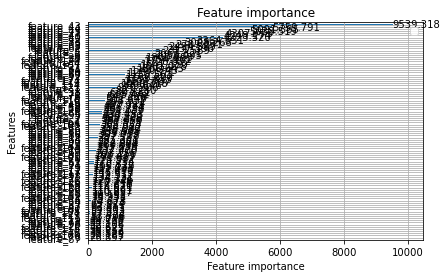

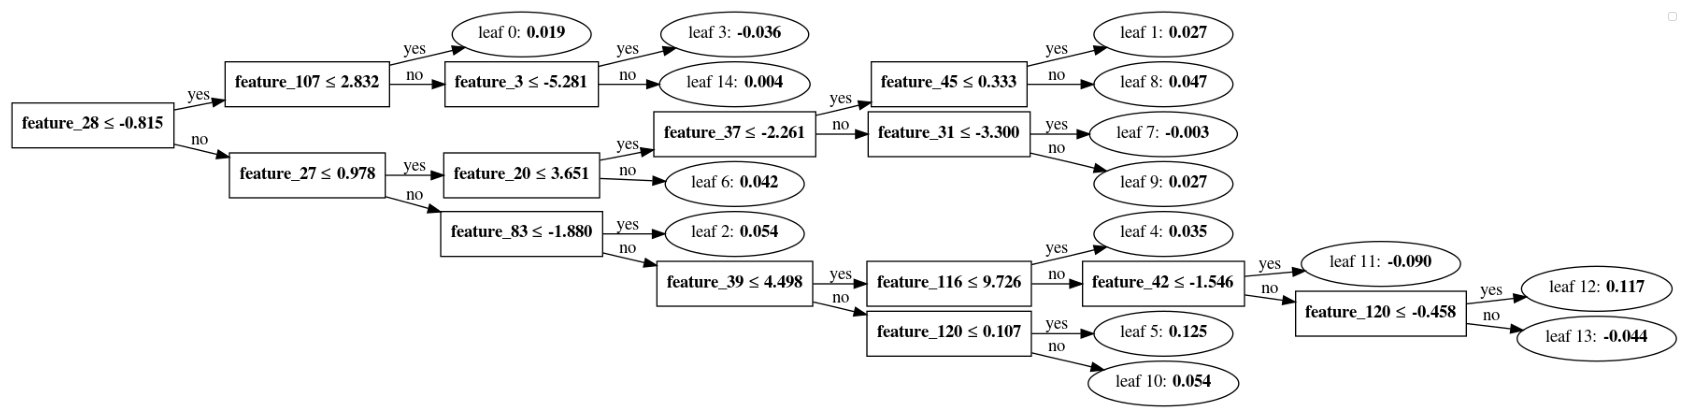

None
41484/41484 [==============================] - 55s 1ms/step - loss: 6.2456 - val_loss: 0.0000e+00
CPU times: user 6min 57s, sys: 26.4 s, total: 7min 24s
Wall time: 4min 36s


In [16]:
%%time
model = Sequential()
model.compile(Adam(lr=0.001),loss="binary_crossentropy", metrics=[Weighted_AUC(lgb_params, X_train, y_train_logit, groups, splits=splits)])
model.fit(
    X_train_adv,
    y_train_adv,
    validation_data=[X_valid_adv, y_valid_adv], 
    shuffle=True, 
    validation_steps=splits
)

# 6. Save files

In [17]:
%%time
# Plots
pickle.dump(X_train_adv, open('X_train_adv.pickle', 'wb'))
pickle.dump(y_train_adv, open('y_train_adv.pickle', 'wb'))
pickle.dump(y_train_logit, open('y_train_logit.pickle', 'wb'))
pickle.dump(X_train, open('X_train.pickle', 'wb'))
# Validation
pickle.dump(X_valid_adv, open('X_valid_adv.pickle', 'wb'))
pickle.dump(y_valid_adv, open('y_valid_adv.pickle', 'wb'))
# Parameters
pickle.dump(lgb_params, open('lgb_params.pickle', 'wb'))
pickle.dump(groups, open('groups.pickle', 'wb'))
pickle.dump(resps, open('resps.pickle', 'wb'))
pickle.dump(weightes, open('weightes.pickle', 'wb'))

CPU times: user 1.89 s, sys: 4.77 s, total: 6.66 s
Wall time: 34.2 s


In [18]:
%%time
# Model
model.save('Logit_LightGBM_CNN_Model.h5')
model.save_weights('Logit_LightGBM_CNN_Model_weights.h5')

CPU times: user 6.73 ms, sys: 3.07 ms, total: 9.8 ms
Wall time: 230 ms


# Appendex
1. A-1. Reconfirm the rules of [Jane Street Market Prediction](https://www.kaggle.com/c/jane-street-market-prediction/overview)
1. A-2. References
1. A-3. Acknowledgment

## A-1. Reconfirm the rules of [Jane Street Market Prediction](https://www.kaggle.com/c/jane-street-market-prediction/overview)
### Quote: [Jane Street| Details(explained) | EDA | Metric](https://www.kaggle.com/mrutyunjaybiswal/jane-street-details-explained-eda-metrics)

## A-1.1. Brief Description
### A-1.1.1. About
Developing trading strategies to identify and take advantage of inefficiencies is challenging. Even if a strategy is profitable now, it may not be in the future, and market volatility makes it impossible to predict the profitability of any given trade with certainty. As a result, it can be hard to distinguish good luck from having made a good trading decision.

In the first three months of this challenge, you will build your own quantitative trading model to maximize returns using market data from a major global stock exchange. Next, you’ll test the predictiveness of your models against future market returns and receive feedback on the leaderboard.

### A-1.1.2. Challenge Brief
Your challenge will be to use the historical data, mathematical tools, and technological tools at your disposal to create a model that gets as close to certainty as possible. You will be presented with a number of potential trading opportunities, which your model must choose whether to accept or reject.

In general, if one is able to generate a highly predictive model which selects the right trades to execute, they would also be playing an important role in sending the market signals that push prices closer to “fair” values. That is, a better model will mean the market will be more efficient going forward. However, developing good models will be challenging for many reasons, including a very low signal-to-noise ratio, potential redundancy, strong feature correlation, and difficulty of coming up with a proper mathematical formulation.

### A-1.1.3. Organizers
Jane Street has spent decades developing their own trading models and machine learning solutions to identify profitable opportunities and quickly decide whether to execute trades. These models help Jane Street trade thousands of financial products each day across 200 trading venues around the world.
Admittedly, this challenge far oversimplifies the depth of the quantitative problems Jane Streeters work on daily, and Jane Street is happy with the performance of its existing trading model for this particular question. However, there’s nothing like a good puzzle, and this challenge will hopefully serve as a fun introduction to a type of data science problem that a Jane Streeter might tackle on a daily basis. Jane Street looks forward to seeing the new and creative approaches the Kaggle community will take to solve this trading challenge.

## A-1.2. Evaluation and Submission
### A-1.2.1 Metric
### Utility Score
Each row in the test set represents a trading opportunity for which we will be predicting an action value, **1 to make the trade and 0 to pass on it**. Each trade j has an associated weight and resp, which represents a return.
For each date i, we define:
more_vert
$$ p_i = \sum_j(weight_{ij} * resp_{ij} * action_{ij}), $$
$$ t = \frac{\sum p_i }{\sqrt{\sum p_i^2}} * \sqrt{\frac{250}{|i|}}, $$
where $|i|$ is the number of unique dates in the test set. The utility is then defined as:
$$u = min(max(t,0), 6)  \sum p_i.$$

### A-1.2.2 Submission
```
import janestreet
env = janestreet.make_env() # initialize the environment
iter_test = env.iter_test() # an iterator which loops over the test set

for (test_df, sample_prediction_df) in iter_test:
    sample_prediction_df.action = 0 #make your 0/1 prediction here
    env.predict(sample_prediction_df)
```
### A-1.2.3 Code Requirements
Yes, this is a code competition, hence it has certain requirements for submission. Submissions to this competition must be made through Notebooks. For this competition, training is not required in Notebooks. In order for to be eligible for submission, the following conditions must be met:

### Training Phase
- Your notebook must use the time-series module to make predictions
- CPU Notebook <= 4 hours run-time
- GPU Notebook <= 4 hours run-time
- Freely & publicly available external data is allowed, including pre-trained models

### Forecasting Phase
Because the size of the test set will change during the live forecasting phase, the time limits will be adjusted in proportion to the test set size, with a **10% added time allowance**. As a hypothetical example, if there are <span style="color:red">1,000,000 test rows</span> and a <span style="color:red">4 hour runtime</span> limit during the **training phase** and the **forecasting phase** has <span style="color:red">2,000,000 rows</span>, your notebook will be allowed **8 hours + 10% = 8.8 hours during the forecasting phase**.

This dataset contains an anonymized set of features, <span style="color:red">feature_{0...129}</span>, representing real stock market data. 
1. Each row in the dataset represents a trading opportunity, for which you will be predicting an action value: 
    - 1 to make the trade and 
    - 0 to pass on it. 

2. Each trade has an associated <span style="color:red">weight and resp</span>, which together represents a return on the trade. 
3. The `date column` is an **integer** which represents the day of the trade.
4. The `ts_id` represents a time ordering. 
5. In addition to anonymized feature values, you are provided with metadata about the features in `features.csv`.

## A-1.3. Data Overview
### A-1.3.1. Train.csv
- In the training set, train.csv, you are provided a resp value, as well as several other resp_{1,2,3,4} values that represent returns over different time horizons. These variables are not included in the test set. 
- **Non-Scored:** Trades with weight = 0 were intentionally included in the dataset for completeness, although such trades will not contribute towards the scoring evaluation.

### A-1.3.2. Test Set
- During the model training phase of the competition, this unseen test set is comprised of historical data.
- During the live forecasting phase, the test set will use periodically updated live market data.
- Note that during the second (forecasting) phase of the competition, the notebook time limits will scale with the number of trades presented in the test set.
    1. **example_test.csv** - a mock test set which represents the structure of the unseen test set. You will not be directly using the test set or sample submission in this competition, as the time-series API will get/set the test set and predictions.
    2. **example_sample_submission.csv** - a mock sample submission file in the correct format

## A-2. References:
1. [Evaluation Custom Metrics](https://www.kaggle.com/c/jane-street-market-prediction/overview/evaluation)
    - [Expanding-window & Sharp Weighted Return](https://www.kaggle.com/haozhuai/expanding-window-sharp-weighted-return)
    - [Research with Customized Sharp Weighted](https://www.kaggle.com/satorushibata/research-with-customized-sharp-weighted)
    - [Approx. Utility score for Regression Objective Fnc](https://www.kaggle.com/anlgrbz/approx-utility-score-for-regress-weighted-traing#Custom-Objective-Function-Implementations-for-LGBM)
    - [Customized Sharp weighted return for Lightgbm & Xgboost](https://www.kaggle.com/c/jane-street-market-prediction/discussion/200915)
1. Data preparation
    - [Optimized LightGBM Classifier on Utility Score](https://www.kaggle.com/satorushibata/optimized-lightgbm-classifier-on-utility-score)
    - [Visualization Model with Customized Sharp Weighted](https://www.kaggle.com/satorushibata/visualization-model-with-customized-sharp-weighted)
    - [Optimize LightGBM HyperParameter with Optuna](https://www.kaggle.com/satorushibata/optimize-lightgbm-hyperparameter-with-optuna)
    - [Optimize CatBoost HyperParameter with Optuna](https://www.kaggle.com/satorushibata/optimize-catboost-hyperparameter-with-optuna)
1. CNN
    - [Simple CNN Useing Keras(~99% Recall,~ 90% AUC)](https://www.kaggle.com/avatarkorra/simple-cnn-useing-keras-99-recall-90-auc/notebook)
    - [ModelクラスAPI](https://keras.io/ja/models/model/)
1. Plot & Summaries
    - [Jane Street Market - Baseline Logistic Regression](https://www.kaggle.com/abiolatti/jane-street-market-baseline-logistic-regression)
1. Reconfirm the rules of [Jane Street Market Prediction](https://www.kaggle.com/c/jane-street-market-prediction/overview)
     - [Jane Street| Details(explained) | EDA | Metric](https://www.kaggle.com/mrutyunjaybiswal/jane-street-details-explained-eda-metrics)
1. Table of Contents
    - [PUBG Data Exploration + RF (+ Funny GIFs)](https://www.kaggle.com/carlolepelaars/pubg-data-exploration-rf-funny-gifs#Table-of-Contents)

## A-3. Acknowledgment
- [@Anil](https://www.kaggle.com/anlgrbz)
- [@WangMH](https://www.kaggle.com/haozhuai)
- [@Amedeo Biolatti](https://www.kaggle.com/abiolatti)
- [@Ultron](https://www.kaggle.com/mrutyunjaybiswal)